#Linearna i polinomijalna regresija

Razmatramo prost primer sa jednim skalarnim regresorom (odlikom, prediktorom) $x$. Ciljna promenljiva $y$ se dobija tako što se na polinom 4. rada od $x$ doda Gaussov šum. 

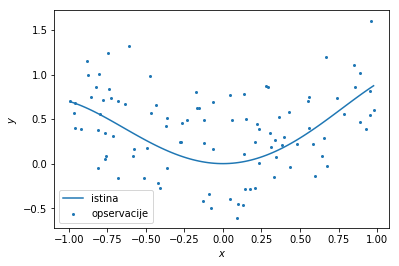

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Broj opservacija
num_ops = 100

# Odlike x su uniformno raspodeljene na intervalu [-1, 1]
rng = np.random.RandomState(0)
x = 2*rng.rand(num_ops, 1) - 1
     
# Opservacije y su šum + polinom 4. reda od x
f = lambda t: 1.2 * t**2 + .1 * t**3 - .4 * t**4
y = f(x) + .4 * rng.normal(size=(num_ops, 1))

# Tačke u kojima procenjujemo estimiranu zavisnost
x_test = np.linspace(min(x), max(x), 100).reshape(-1, 1)
y_true = f(x_test)

# Grafik
plt.figure(figsize=(6, 4))
plt.scatter(x, y, s=4, label='opservacije')
plt.plot(x_test, y_true, label='istina')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

## Obična linearna regresija
Najpre ćemo usvojiti model tipa
$$
\hat{y} = h_{\theta}(x) = \theta_0 + \theta_1 x
$$

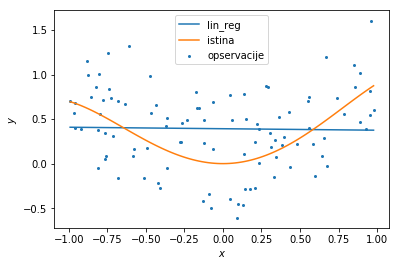

In [2]:
from sklearn.linear_model import LinearRegression

# Instanciramo objekat tipa LinearRegression
lin_reg = LinearRegression()

# Određujemo parametre regresora (x mora biti vektor-kolona)
lin_reg.fit(x, y)

# Procenjujemo vrednosti na intervalu od interesa
y_pred = lin_reg.predict(x_test)

# Grafik
plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='opservacije', s=4)
plt.plot(x_test, y_pred, label='lin_reg')
plt.plot(x_test, y_true, label='istina')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

## Polinomijalna regresija
Obična (inkrementalno) linearna zavisnost deluje kao previše gruba aproksimacija. Model možemo učiniti nelinearnim u odnosu na prediktore ali i dalje linearnim u odnosu na parametre $\theta$ uvođenjem dodatnih prediktora koje dobijamo nelinearnim preslikavanjima originalnih prediktora. Najčešće su to stepeni originalnog prediktora. Npr. model 2. reda dobijamo kao
$$
h_\theta(x) = \theta_0 + \theta_1 x + \theta_2 x^2
$$
Da smo imali dva originalna prediktora $x_1$ i $x_2$, onda bi hipoteza sadržala i članove tipa $x_2^2$, $x_1 x_2$ itd.
Obučićemo model 4. reda. Probajte da promenite red modela.


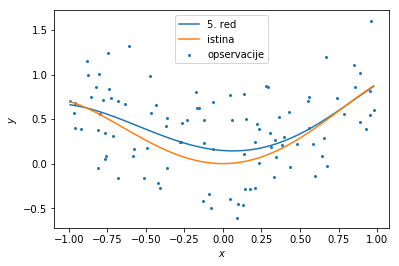

In [3]:
#@title Polinomijalna regresija p-tog reda
# Dodajemo "nove" odlike x^2, ..., x^p
p = 5  #@param {type: 'integer'}
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=p, include_bias=False)
X_poly = poly_features.fit_transform(x)
lin_reg.fit(X_poly, y)
y_pred = lin_reg.predict(poly_features.fit_transform(x_test))

# Grafik
plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='opservacije', s=4)
plt.plot(x_test, y_pred, label='{}. red'.format(p))
plt.plot(x_test, y_true, label='istina')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

Pomoću module `sklearn.pipeline` možemo da automatizujemo dodavanje odlika i regresiju.

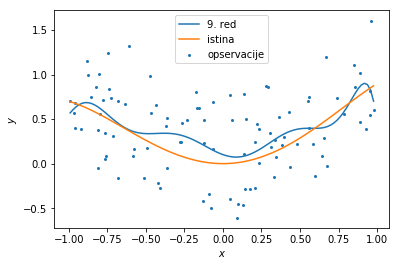

In [4]:
# Možemo da automatizujemo dodavanje polinomijalnih odlika i linearnu regresiju
from sklearn.pipeline import make_pipeline
model = make_pipeline(PolynomialFeatures(degree=9, include_bias=False), LinearRegression())
model.fit(x, y)
y_pred = model.predict(x_test)

# Grafik
plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='opservacije', s=4)
plt.plot(x_test, y_pred, label='9. red')
plt.plot(x_test, y_true, label='istina')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

##Izbor "optimalnog" reda unakrsnom validacijom
Povećanjem reda polinoma, model dobija na fleksibilnosti, što rezultuje manjom srednje-kvadratnom greškom. Dovoljno visokim redom možemo da ostvarimo i nultu srednje-kvadratnu grešku. Ovo očigledno nije dobra ideja, jer će doći do preobučavanja. "Optimalni" red biramo tako što parametre polinoma određujemo na trenirajućem skupu, a srednje-kvadratnu grešku (ili neku drugu metriku do koje nam je stalo) računamo na odvojenom, validacionom skupu podataka.

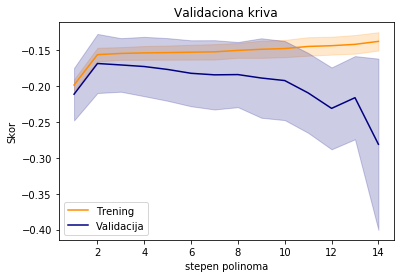

In [5]:
from sklearn.model_selection import validation_curve

# Probamo polinome različitih redova i računamo greške obučavanja i validacije
degree = np.arange(1, 15)
train_scores, test_scores = validation_curve(
                model, x, y,
                param_name='polynomialfeatures__degree',
                param_range=degree,
                cv=5,
                scoring='neg_mean_squared_error')

# Svaka kolona sadrži skor za jedan "struk" unakrsne validacije.
# Svaka vrsta odgovara jednom konkretnom redu polinoma.
# Strukove koristimo da sračunamo srednju vrednost 
# i standardnu devijaciju skora za svaki pojedinačni stepem polinoma.
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validaciona kriva")
plt.xlabel("stepen polinoma")
plt.ylabel("Skor")
lw = 2
plt.plot(degree, train_scores_mean, label="Trening",
            color="darkorange")
plt.fill_between(degree, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
plt.plot(degree, test_scores_mean, label="Validacija",
             color="navy")
plt.fill_between(degree, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy")
plt.legend(loc="best")
plt.show()

Sa gornjeg grafika izgleda kao da je optimalan red modela 2 ili 3.

## Regularizacija: grebena (ridge) regresija i LASSO
Da bismo izbegli preobučavanje, moramo da usvojimo relativno jednostavan model (polinom niskog reda), ali to istovremeno ograničava i fleksibilnost, odnosno smanjuje ekspresivnu moć našeg modela. Alternativni pristup podrazumeva korišćenje kompleksnog modela i upotrebu regularizacije u cilju sprečavanja preobučavanja. Najčešći vid regularizacije jeste penalizacija $L_p$ norme parametara, pa je kriterijum koji minimiziramo linearna kombinacija srednje-kvadratne greške i člana tipa $\|\theta\|_p^p$. Tipično usvajamo
* $p=2$: grebena regresija, ili
* $p=1$: LASSO

Optimalnu vrednost "jačine" regularizacije biramo unakrsnom validacijom.

### Standardizacija
Regularizacija podjednako penalizuje sve koeficijente modela. Međutim, ukoliko su vrednosti prediktora $x_i$ značajno veće nego vrednosti nekog drugog prediktora $x_j$, onda je razumno očekivati da će koeficijent $\theta_i$ biti po apsolutnoj vrednosti manji od $\theta_j$, iako je možda $x_i$ informativniji od $x_j$. Npr kvadratura iskazana u kvadratnim metrima i broj soba su približno podjednako informativni za predikciju cene stana, ali će naučeni koeficijent koji množi kvadraturu skoro sigurno biti manji od onog koji množi broj soba (primetite da su ova dva prediktora verovatno snažno korelisana, što samo po sebi može da bude problematično, ali ćemo to zanemariti u ovoj diskusiji). 

Dobra praksa koja velikim delom rešava opisani problem (i neke druge koje nismo pomenuli) jeste da se vrednosti svih prediktora svedu u uporedive opsege. Jedan od najčešćih načina kojima se ovo postiže je *standardizacija*: od svakog prediktora se oduzima njegova srednja vrednost, a zatim se on deli svojom standardnom devijacijom; nakon toga, svi prediktori imaju nulto očekivanje i jediničnu varijansu. 

Parametre standardizacije (srednje vrednosti i standardne devijacije) procenjujemo na obučavajućem skupu, a zatim pomoću njih transformišemo i sve naredne (nove) opservacije.


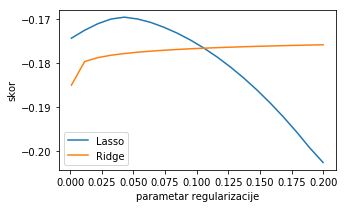

In [14]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Sintetišemo polinomijalne odlike
X_9 = PolynomialFeatures(degree=9, include_bias=False).fit_transform(x)

# Standardizacija
scaler = StandardScaler().fit(X_9)
X_9 = scaler.transform(X_9)

plt.figure(figsize=(5, 3))

# Opseg parametra regularizacije
alphas = np.linspace(1e-3, 0.2, 20)

for Model in [Lasso, Ridge]:
    # Računamo samo srednju vrednost skora za 3 struka unakrsne validacije
    # (ne crtamo intervale poverenja):
    scores = [cross_val_score(Model(alpha), X_9, y, cv=3, 
                              scoring='neg_mean_squared_error').mean()
            for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)
    

plt.legend(loc='best')
plt.xlabel('parametar regularizacije')
plt.ylabel('skor')
plt.tight_layout()
plt.show()

U sklearn postoje posebne f-je koje automatski određuju optimalan parametar regularizacije.

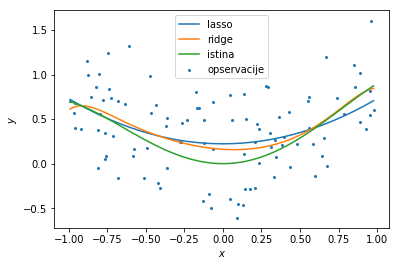

In [7]:
# Automatski izbor najbolje vrednosti parametra regularizacije
from sklearn.linear_model import LassoCV, RidgeCV
lasso_reg = LassoCV(cv=5, alphas=[1e-3, 5e-2]).fit(X_9, np.squeeze(y))
ridge_reg = RidgeCV(cv=5, alphas=[1e-3, 0.3]).fit(X_9, np.squeeze(y))

# Evaluacija na test skupu
X_test = PolynomialFeatures(degree=9, include_bias=False).fit_transform(x_test)
X_test = scaler.transform(X_test)
y_pred_lasso = lasso_reg.predict(X_test)
y_pred_ridge = ridge_reg.predict(X_test)


# Grafik
plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='opservacije', s=4)
plt.plot(x_test, y_pred_lasso, label='lasso')
plt.plot(x_test, y_pred_ridge, label='ridge')
plt.plot(x_test, y_true, label='istina')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()


Između dobijenih hipoteza nema značajne razlike. Međutim, LASSO ima tendenciju da neke parametre postavi na vrednost nula, čime efektivno automatski vrši izbor najboljih prediktora, a dobijeni model je "proređen".

In [8]:
# Koeficijenti
print('Lasso koeficijenti')
print(lasso_reg.coef_)
print('Ridge koeficijenti')
print(ridge_reg.coef_)


Lasso koeficijenti
[0.         0.15546646 0.         0.         0.         0.
 0.         0.         0.        ]
Ridge koeficijenti
[-0.06203894  0.21200155  0.1074272   0.02759615 -0.0229945   0.07036155
 -0.00818488 -0.11358235  0.01356856]
